In [126]:
#%%imports
import importlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from lstein import (
    utils as lsu,
    makedata as md
)
from lstein import lstein
importlib.reload(lstein)


<module 'lstein.lstein' from '/home/lukas/github/LStein/src/lstein/lstein.py'>

### Get Data

In [127]:
#generate some data
raw, pro = md.simulate(opt="sin", theta=np.array([10,15,20,25,30]))
df_raw = pl.from_dict(raw).with_columns(pl.col("amplitude")+1e-3*pl.col("time")**2) #add quadratic trend to mae sure difference for y-inversion is visible
df_pro = pl.from_dict(pro).with_columns(pl.col("amplitude")+1e-3*pl.col("time")**2) #add quadratic trend to mae sure difference for y-inversion is visible
print(df_raw)

shape: (2_500, 5)
┌────────┬────────────┬───────────┬─────────────┬────────────┐
│ period ┆ time       ┆ amplitude ┆ amplitude_e ┆ processing │
│ ---    ┆ ---        ┆ ---       ┆ ---         ┆ ---        │
│ i64    ┆ f64        ┆ f64       ┆ f64         ┆ str        │
╞════════╪════════════╪═══════════╪═════════════╪════════════╡
│ 10     ┆ -49.699399 ┆ 2.953077  ┆ NaN         ┆ raw        │
│ 10     ┆ -49.398798 ┆ 2.807423  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.797595 ┆ 3.581737  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.797595 ┆ 2.979183  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.496994 ┆ 2.959245  ┆ NaN         ┆ raw        │
│ …      ┆ …          ┆ …         ┆ …           ┆ …          │
│ 30     ┆ 99.098196  ┆ 10.329752 ┆ NaN         ┆ raw        │
│ 30     ┆ 99.098196  ┆ 10.063045 ┆ NaN         ┆ raw        │
│ 30     ┆ 99.098196  ┆ 10.899644 ┆ NaN         ┆ raw        │
│ 30     ┆ 99.098196  ┆ 10.861311 ┆ NaN         ┆ raw        │
│ 30     ┆ 99.098196  ┆ 10.808276 ┆ N

In [128]:
#get dimensions

##raw
df_raw_p = df_raw.partition_by("period")    #partition by unique values in `"period"`
theta_raw = [df["period"].to_numpy()[0] for df in df_raw_p]    #only one value per series
x_raw = [df["time"].to_numpy() for df in df_raw_p]             #K values per series
y_raw = [df["amplitude"].to_numpy() for df in df_raw_p]        #K values per series

##processed
df_pro_p = df_pro.partition_by("period")    #partition by unique values in `"period"`
theta_pro = [df["period"].to_numpy()[0] for df in df_pro_p]    #only one value per series
x_pro = [df["time"].to_numpy() for df in df_pro_p]             #K values per series
y_pro = [df["amplitude"].to_numpy() for df in df_pro_p]        #K values per series

### Setup Variations

In [129]:
#global parameters
thetaticks = np.array(theta_raw).astype(int)
xticks = np.linspace(-45, 80, 6).astype(int)
yticks = np.linspace(-3,3,3).astype(int)

thetalabel = r"$\theta$"
xlabel = r"$x$"
ylabel = r"$y$"

#init list of canvases
LSCs = []

In [130]:
#standard
thetaguidelims = (-np.pi/2,np.pi/2)
panelsize = np.pi/4
LSCs.append(lstein.LSteinCanvas(
    thetaticks=thetaticks, xticks=xticks, yticks=yticks,
    thetaguidelims=thetaguidelims, thetaplotlims=(thetaguidelims[0]+panelsize/2, thetaguidelims[1]-panelsize/2),
    panelsize=panelsize,
    thetalabel=thetalabel, xlabel=xlabel, ylabel=ylabel,
))


In [131]:
#inversion of theta
thetaguidelims = (np.pi/2,-np.pi/2)
panelsize = np.pi/4
LSCs.append(lstein.LSteinCanvas(
    thetaticks=thetaticks, xticks=xticks, yticks=yticks,
    thetaguidelims=thetaguidelims, thetaplotlims=(thetaguidelims[0]-panelsize/2, thetaguidelims[1]+panelsize/2),    #NOTE: inversion of signs!
    panelsize=panelsize,
    thetalabel=thetalabel, xlabel=xlabel, ylabel=ylabel,
))


In [132]:
#inversion of x
thetaguidelims = (-np.pi/2,np.pi/2)
panelsize = np.pi/4
LSCs.append(lstein.LSteinCanvas(
    thetaticks=thetaticks, xticks=xticks[::-1], yticks=yticks,
    thetaguidelims=thetaguidelims, thetaplotlims=(thetaguidelims[0]+panelsize/2, thetaguidelims[1]-panelsize/2),
    panelsize=panelsize,
    thetalabel=thetalabel, xlabel=xlabel, ylabel=ylabel,
))


In [133]:
#inversion of y
thetaguidelims = (-np.pi/2,np.pi/2)
panelsize = np.pi/4
LSCs.append(lstein.LSteinCanvas(
    thetaticks=thetaticks, xticks=xticks, yticks=yticks[::-1],
    thetaguidelims=thetaguidelims, thetaplotlims=(thetaguidelims[0]+panelsize/2, thetaguidelims[1]-panelsize/2),
    panelsize=panelsize,
    thetalabel=thetalabel, xlabel=xlabel, ylabel=ylabel,
))


### Add Panels and Data

In [134]:
for LSC in LSCs:
    #add panels
    for i in range(len(theta_raw)):
        
        #add a panel (similar to `ax = fig.add_subplot()`)
        LSP = LSC.add_panel(
            theta=theta_raw[i], #add panel at `theta_raw[i]`
        )

        #add a series to the panel
        LSP.plot(x_pro[i], y_pro[i], seriestype="line", lw=3)


### Display Plot

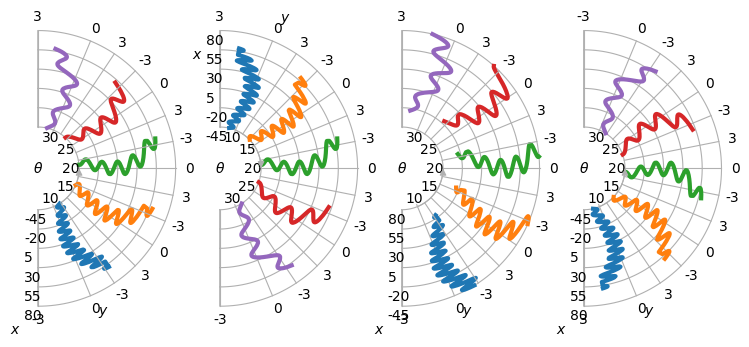

In [135]:
fig, axs = plt.subplots(1,4, figsize=(9,7))
axs = axs.flatten()
for idx in range(len(LSCs)):
    lstein.LSteinMPL(LSCs[idx]).show(axs[idx])
    # fig = lstein.draw(LSC)
plt.show()